In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import numpy as np
import cirq
import sympy
from scipy.io import loadmat

In [3]:
(x_train_ori, y_train_ori), (x_test_ori, y_test_ori) = tf.keras.datasets.mnist.load_data()
test_data_path = 'data/MNIST_Test_Nox16.mat'
train_data_path = 'data/MNIST_Train_Nox16.mat'

test_data = loadmat(test_data_path)
train_data = loadmat(train_data_path)

x_train_ori = train_data['VV']/255.0
x_test_ori = test_data['UU']/255.0

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y.astype(int)

x_train, y_train = filter_36(x_train_ori, y_train_ori)
x_test, y_test = filter_36(x_test_ori, y_test_ori)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [4]:
# Convert grayscale images to binary images
THRESHOLD = 0.2
x_train = np.array(x_train > THRESHOLD, dtype=np.float32)
x_test = np.array(x_test > THRESHOLD, dtype=np.float32)

In [5]:
def create_classical_model():
    # A simple FNN with three neurons and two layers
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(16,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [6]:
mlp_history = model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test))

binin_nn_results = model.evaluate(x_test, y_test)

2024-03-16 22:16:13.215983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
95/95 - 1s - loss: 0.8865 - accuracy: 0.4901 - val_loss: 0.7484 - val_accuracy: 0.4837
Epoch 2/10
95/95 - 0s - loss: 0.6866 - accuracy: 0.5552 - val_loss: 0.6498 - val_accuracy: 0.6479
Epoch 3/10
95/95 - 0s - loss: 0.6343 - accuracy: 0.6941 - val_loss: 0.6160 - val_accuracy: 0.7490
Epoch 4/10
95/95 - 0s - loss: 0.6054 - accuracy: 0.7681 - val_loss: 0.5881 - val_accuracy: 0.7739
Epoch 5/10
95/95 - 0s - loss: 0.5791 - accuracy: 0.7830 - val_loss: 0.5622 - val_accuracy: 0.7947
Epoch 6/10
95/95 - 0s - loss: 0.5540 - accuracy: 0.8150 - val_loss: 0.5370 - val_accuracy: 0.8247
Epoch 7/10
95/95 - 0s - loss: 0.5288 - accuracy: 0.8260 - val_loss: 0.5123 - val_accuracy: 0.8328
Epoch 8/10
95/95 - 0s - loss: 0.5041 - accuracy: 0.8342 - val_loss: 0.4883 - val_accuracy: 0.8394
Epoch 9/10
95/95 - 0s - loss: 0.4802 - accuracy: 0.8631 - val_loss: 0.4651 - val_accuracy: 0.8791
Epoch 10/10
95/95 - 0s - loss: 0.4573 - accuracy: 0.8753 - val_loss: 0.4433 - val_accuracy: 0.8796
62/62 [============

In [7]:
# Encode classical data into quantum states
def convert_to_circuit(data, label, n_qubits):
    qubits = cirq.GridQubit.rect(1, n_qubits)
    circuit = cirq.Circuit()
    for n in range(n_qubits-1):
        if data[n] == 1:
            circuit.append(cirq.X(qubits[n]))
    if label == 1:
        circuit.append(cirq.X(qubits[-1]))
    return circuit

n_qubits = len(x_train[0]) + 1
x_train_circ = [convert_to_circuit(x, y, n_qubits) 
                    for (x,y) in zip(x_train, y_train)]
x_test_circ = [convert_to_circuit(x, y, n_qubits) 
                    for (x,y) in zip(x_test, y_test)]
#print(x_train_circ[0])

# Convert Cirq circuits to tensors for tfq
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [8]:
def qn_circuit(input_qubits, circuit, out_qubit, para):
  # Define a quantum neuron
  for i, qubit in enumerate(input_qubits):
    circuit.append(cirq.ry(para[i])(out_qubit).controlled_by(input_qubits[i]))
  circuit.append(cirq.rz(para[-2])(out_qubit))
  circuit.append(cirq.ry(para[-1])(out_qubit))

In [9]:
def create_quantum_model(n_qubits):
    # Build a QNN with three quantum neurons and two layers
    data_qubits = cirq.GridQubit.rect(1, n_qubits)
    symbols = sympy.symbols('theta0:59')  # 39 parameters
    circ = cirq.Circuit()
    readout = cirq.GridQubit(-4, -4)
    qn_circuit(data_qubits[:-1], circ, cirq.GridQubit(-1, -1), symbols[0:18])
    qn_circuit(data_qubits[:-1], circ, cirq.GridQubit(-2, -2), symbols[18:36])
    qn_circuit(data_qubits[:-1], circ, cirq.GridQubit(-3, -3), symbols[36:54])
    qn_circuit([cirq.GridQubit(-3, -3), cirq.GridQubit(-2, -2), cirq.GridQubit(-1, -1)], 
                circ, readout, symbols[54:59])
    circ.append(cirq.ry(0)(data_qubits[-1])) 
    op = cirq.Z(readout) * cirq.Z(data_qubits[-1])
    return circ, op
    
model_circuit, op = create_quantum_model(n_qubits)
print(model_circuit)

                          ┌─────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────┐   ┌────────────────────────────────┐   ┌─────────────────────────────────┐   ┌─────────────────────────────────┐   ┌─────────────────────────────────┐   ┌─────────────────────────────────┐   ┌─────────────────────────────────┐   ┌─────────────────────────────────┐   ┌─────────────────────────────────┐   ┌──────────────────────┐
(-4, -4): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [10]:
# Keras model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, op),
])

In [11]:
# Define a custom hinge_accuracy metric
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)

In [12]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[hinge_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 59        
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# <zy|Z_z Z_y|zy> = 1 signify perfect training
y_train_label = np.ones(len(y_train))
y_test_label = np.ones(len(y_test))

In [14]:
qnn_history = model.fit(
      x_train_tfcirc, y_train_label,
      batch_size=128,
      epochs=10,
      verbose=2,
      validation_data=(x_test_tfcirc, y_test_label))

qnn_results = model.evaluate(x_test_tfcirc, y_test_label)

Epoch 1/10
95/95 - 5782s - loss: 0.8974 - hinge_accuracy: 0.6383 - val_loss: 0.8262 - val_hinge_accuracy: 0.6948
Epoch 2/10
95/95 - 5811s - loss: 0.7065 - hinge_accuracy: 0.7477 - val_loss: 0.5967 - val_hinge_accuracy: 0.8298
Epoch 3/10
95/95 - 5840s - loss: 0.4944 - hinge_accuracy: 0.8709 - val_loss: 0.4132 - val_hinge_accuracy: 0.8937
Epoch 4/10
95/95 - 5823s - loss: 0.3880 - hinge_accuracy: 0.8919 - val_loss: 0.3638 - val_hinge_accuracy: 0.8937
Epoch 5/10
95/95 - 5835s - loss: 0.3633 - hinge_accuracy: 0.8810 - val_loss: 0.3564 - val_hinge_accuracy: 0.8592
Epoch 6/10
95/95 - 5814s - loss: 0.3588 - hinge_accuracy: 0.8712 - val_loss: 0.3536 - val_hinge_accuracy: 0.8660
Epoch 7/10
95/95 - 5808s - loss: 0.3575 - hinge_accuracy: 0.8674 - val_loss: 0.3534 - val_hinge_accuracy: 0.8665
Epoch 8/10
95/95 - 5815s - loss: 0.3576 - hinge_accuracy: 0.8666 - val_loss: 0.3545 - val_hinge_accuracy: 0.8665
Epoch 9/10
95/95 - 5822s - loss: 0.3569 - hinge_accuracy: 0.8722 - val_loss: 0.3468 - val_hinge_

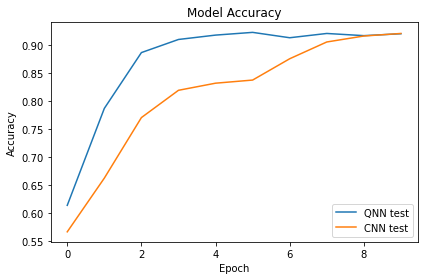

In [61]:
plt.plot(qnn_history.history['val_hinge_accuracy'], color='C0')
plt.plot(mlp_history.history['val_accuracy'], color='C1')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['QNN test', 'CNN test'])

plt.tight_layout()
plt.show()